# Libaries + intit

In [ ]:
!pip install transformers
# !pip install torchviz

     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 6.6 MB 19.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set_theme()
from google.colab import drive 
import random
from tqdm.auto import tqdm
from collections import defaultdict

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#deep learning / pytorch
import torch 
from torch import nn, optim
from transformers import AutoTokenizer, AutoModelForPreTraining, AdamW, get_scheduler, get_linear_schedule_with_warmup, logging, ElectraModel
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from torchviz import make_dot

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data cleaning + Data Split

In [ ]:
#get data
drive_path = 'gdrive/My Drive/DTU/Special kursus/data_small/'
df = pd.read_csv(drive_path+'hadtale_kurateret.csv',sep='\t')

# Seperate comments from 'core'  text.
df['comment_text']=df['comment_text'].apply(lambda x: x.split('\n'))
df['comment_text_core']=df['comment_text'].apply(lambda x: x[0])
df['comment_text_comments']=df['comment_text'].apply(lambda x: x[1:])

def remove_empty_strings(a_list):
  without_empty_strings = []
  for string in a_list:
      if (string != ""):
          without_empty_strings.append(string)
  return without_empty_strings

df['comment_text_comments']=df['comment_text_comments'].apply(lambda x: remove_empty_strings(x))
df['comment_text_N_comments']=df['comment_text_comments'].apply(lambda x: len(x))

# one-hot encoding
df=df.join(pd.get_dummies(df['class_text']))

#split
df_train,df_test=train_test_split(df,test_size=0.4,random_state=1)
df_test,df_eval=train_test_split(df_test,test_size=0.25,random_state=1)

print('Train size: ' + str(len(df_train))+' - '+str(len(df_train)/len(df)*100)+' %')
print('Test size: ' + str(len(df_test))+' - '+str(len(df_test)/len(df)*100)+' %')
print('Validation size: ' + str(len(df_eval))+' - '+str(len(df_eval)/len(df)*100)+' %')

df_train.head()

Train size: 1200 - 60.0 %
Test size: 600 - 30.0 %
Validation size: 200 - 10.0 %


,class,class_text,comment_text,comment_text_core,comment_text_comments,comment_text_N_comments,andet,hadtale
1616,2,hadtale,[Føj.. Jeg bliver dårlig over at læse det. Han...,Føj.. Jeg bliver dårlig over at læse det. Han ...,[],0,0,1
1695,2,hadtale,[Hvorfor bruge tid på at dele hans historie. F...,Hvorfor bruge tid på at dele hans historie. Fu...,[],0,0,1
35,0,andet,[Venstre regeringen gav heller ikke noget til ...,Venstre regeringen gav heller ikke noget til A...,[],0,1,0
941,0,andet,[Du ser også gammel ud ift mig 😂😂🤪🥳😘],Du ser også gammel ud ift mig 😂😂🤪🥳😘,[],0,1,0
1386,2,hadtale,[Tony robbins er også en klam børnepiller. Men...,Tony robbins er også en klam børnepiller. Men ...,[],0,0,1


# Data Prep - Dataloader + Tokenizer

In [ ]:
electra_huggingface='Maltehb/aelaectra-danish-electra-small-cased'
tokenizer = AutoTokenizer.from_pretrained(electra_huggingface)

Downloading:   0%|          | 0.00/111 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class Dataset():
  def __init__(self, texts, targets, tokenizer, max_len):
    self.text = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
def create_dataloader(df, tokenizer, max_len, batch_size):
  ds = Dataset(
    texts=df["comment_text_core"].to_numpy(),
    targets=df['hadtale'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(ds,batch_size=batch_size,num_workers=2)


train_dataloader = create_dataloader(df_train, tokenizer, 200, 8)
test_dataloader = create_dataloader(df_test, tokenizer, 200, 8)
eval_dataloader = create_dataloader(df_eval, tokenizer, 200, 8)

# Model

## Init

In [ ]:
#init
logging.set_verbosity_error() #Remove warning msg - missing fine-tunning
electraModel = ElectraModel.from_pretrained(electra_huggingface)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Downloading:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

cuda:0


In [ ]:
class ElectraClassifier(nn.Module):
    def __init__(self,num_labels=2):
        super(ElectraClassifier, self).__init__()
        self.num_labels = num_labels
        self.electra = ElectraModel.from_pretrained(electra_huggingface)
        self.dense1 = nn.Linear(self.electra.config.hidden_size, self.electra.config.hidden_size)
        self.dropout1 = nn.Dropout(self.electra.config.hidden_dropout_prob)
        self.dropout2 = nn.Dropout(self.electra.config.hidden_dropout_prob)
        self.out_proj = nn.Linear(self.electra.config.hidden_size, self.num_labels)

    def classifier(self,sequence_output):
        x = sequence_output[:, 0, :]
        x = self.dropout1(x)
        x = F.gelu(self.dense1(x))
        x = self.dropout2(x)
        logits = self.out_proj(x)
        sm = nn.Softmax(dim=1)
        return sm(logits)

    def forward(self, input_ids=None,attention_mask=None):
        discriminator_hidden_states = self.electra(input_ids=input_ids,attention_mask=attention_mask)
        sequence_output = discriminator_hidden_states[0]
        logits = self.classifier(sequence_output)
        return logits

In [ ]:
model = ElectraClassifier()
model = model.to(device)

## ADAM Functions

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(input_ids=input_ids,attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def adam_train(epoch,lr):
  history = defaultdict(list)
  model=ElectraClassifier()
  model = model.to(device)

  EPOCHS = epoch
  optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False,no_deprecation_warning=True)
  total_steps = len(train_dataloader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
  loss_fn = nn.CrossEntropyLoss().to(device)

  best_accuracy = 0
  for epoch in range(EPOCHS):

    train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler,len(df_train))
    val_acc, val_loss = eval_model(model, eval_dataloader, loss_fn, device, len(df_eval))

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  return model, best_accuracy, history

## SGD Functions (SWAG)

In [ ]:
def train_epoch_SWAG(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  model_params = []

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(input_ids=input_ids,attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    model_params.append(model.state_dict())

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses), model_params

In [ ]:
def stream_Avg_Var(arr): #input arr is a list of tensors. 
    n = len(arr)
    avg = arr[0]-arr[0] #zeroes! 
    avg_sq = arr[0]-arr[0] #zeroes! 
    var = arr[0]-arr[0] #zeroes!
    for i in range(n):
        avg = (avg * i + arr[i]) / (i + 1)
        avg_sq += arr[i] * arr[i]
        std = torch.sqrt((avg_sq / i) - (avg*avg)) #var to std
    return avg, std


def train_sgd(base_model,epoch,lr):
  history = defaultdict(list)
  #SGD (SWAG) init
  EPOCHS_swag = epoch
  optimizer_swag = torch.optim.SGD(base_model.parameters(), lr=lr)
  total_steps_swag = len(train_dataloader) * EPOCHS_swag
  scheduler_swag = get_linear_schedule_with_warmup(optimizer_swag,num_warmup_steps=0,num_training_steps=total_steps_swag)
  loss_fn_swag = nn.CrossEntropyLoss().to(device)

  #Train
  SWAG_params = []
  for epoch in range(EPOCHS_swag):
    train_acc, train_loss, model_params = train_epoch_SWAG(base_model, train_dataloader, loss_fn_swag, optimizer_swag, device, scheduler_swag, len(df_train))
    SWAG_params = SWAG_params + model_params

    val_acc, val_loss = eval_model(base_model, eval_dataloader, loss_fn_swag, device, len(df_eval))
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

  #params to dict
  dd = defaultdict(list)
  for d in SWAG_params:
    for key, value in d.items():
        dd[key].append(value) 

  # Stream mean and std
  parameter_mean = {}
  parameter_std = {}
  for name, _ in base_model.named_parameters():
    avg, std = stream_Avg_Var(dd[name])
    parameter_mean[name] = avg
    parameter_std[name] = std.nan_to_num() #replace nan with 0

  return parameter_mean, parameter_std, history

In [ ]:
def sample_new_weights(parameter_mean, parameter_std,model_b):
  weights = {}
  weights['electra.embeddings.position_ids'] = model_b.state_dict()['electra.embeddings.position_ids'] #From ADAM model
  for name, _ in model.named_parameters():
    weights[name] = torch.normal(parameter_mean[name],parameter_std[name])

  return weights

# MULTI SWAG!!

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
#init model
model_sample = ElectraClassifier()
model_sample = model_sample.to(device)

#For multi swag
y_pred_probs_multi_swag = []
y_test_multi_swag = []
f1_ensembles = []

#weight eg
w_eg_true_all1 = []
w_eg_true_all2 = []
w_eg_mean = []
w_eg_std = []

#Training History
adam_train_history=[]
sgd_train_history=[]

#Base model
f1_base_ensembles = []
y_pred_probs_base_ensemble = []
y_test_base_ensemble = []

n_ensembles = 15
for j in range(n_ensembles):

  #Setting new seed
  seed = j
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  #train adam
  base_model, ac, history = adam_train(epoch=50,lr=2e-5)
  _, y_pred_base, y_pred_probs_base, y_test_base = get_predictions(base_model, test_dataloader)
  y_pred_probs_base_ensemble.append(y_pred_probs_base.numpy())
  y_test_base_ensemble.append(y_test_base)
  f1_base = f1_score(y_test_base_ensemble[0], np.argmax(np.array(y_pred_probs_base_ensemble).mean(axis=-3),axis=1), average='macro')
  f1_base_ensembles.append(f1_base)
  adam_train_history.append(history)

  #train SGD
  parameter_mean, parameter_std, history_swag = train_sgd(base_model,epoch=10,lr=1e-2)
  sgd_train_history.append(history_swag)


  #Weights exsample
  w_eg_mean.append(parameter_mean['dense1.weight'][0][0].cpu().detach().numpy())
  w_eg_std.append(parameter_std['dense1.weight'][0][0].cpu().detach().numpy())

  w_eg_true_w1 = []
  w_eg_true_w2 = []
  for i in range(50):
    #sample w from sgd
    sample_w=sample_new_weights(parameter_mean, parameter_std, base_model)
    model_sample.load_state_dict(sample_w)
    
    #get predictions from (multi) swag
    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model_sample, test_dataloader)
    y_pred_probs_multi_swag.append(y_pred_probs.numpy())
    y_test_multi_swag.append(y_test)

    w_eg_true_w1.append(model_sample.state_dict()['dense1.weight'][0][0].cpu().detach().numpy())
    w_eg_true_w2.append(model_sample.state_dict()['dense1.weight'][1][1].cpu().detach().numpy())

    w_eg_true_all1.append(w_eg_true_w1)
    w_eg_true_all2.append(w_eg_true_w2)
  
  #Get f1 macro
  f1 = f1_score(y_test_multi_swag[0], np.argmax(np.array(y_pred_probs_multi_swag).mean(axis=-3),axis=1), average='macro')
  f1_ensembles.append(f1)
  print(str(j+1)+'/'+str(n_ensembles)+' ENSEMBLE \n'+'Multi SWAG F1: ' + str(f1) + ' -- Base model Accuracy: ' + str(ac.cpu().detach().numpy()) + ' -- Base Model F1 score: ' + str(f1_base)+'\n')

1/15 ENSEMBLE 
Multi SWAG F1: 0.8399982222024689 -- Base model Accuracy: 0.86 -- Base Model F1 score: 0.839935974389756

2/15 ENSEMBLE 
Multi SWAG F1: 0.8466598515489577 -- Base model Accuracy: 0.845 -- Base Model F1 score: 0.8482823393418343

3/15 ENSEMBLE 
Multi SWAG F1: 0.8433176650998433 -- Base model Accuracy: 0.835 -- Base Model F1 score: 0.8433263700608917

4/15 ENSEMBLE 
Multi SWAG F1: 0.84831268700462 -- Base model Accuracy: 0.835 -- Base Model F1 score: 0.8449788999058204

5/15 ENSEMBLE 
Multi SWAG F1: 0.84831268700462 -- Base model Accuracy: 0.85 -- Base Model F1 score: 0.8416310336492376

6/15 ENSEMBLE 
Multi SWAG F1: 0.8483228001944579 -- Base model Accuracy: 0.8300000000000001 -- Base Model F1 score: 0.8433263700608917

7/15 ENSEMBLE 
Multi SWAG F1: 0.8516464741034195 -- Base model Accuracy: 0.845 -- Base Model F1 score: 0.8566523318998567

8/15 ENSEMBLE 
Multi SWAG F1: 0.8483295415718726 -- Base model Accuracy: 0.85 -- Base Model F1 score: 0.8499933330370238

9/15 ENSEMB

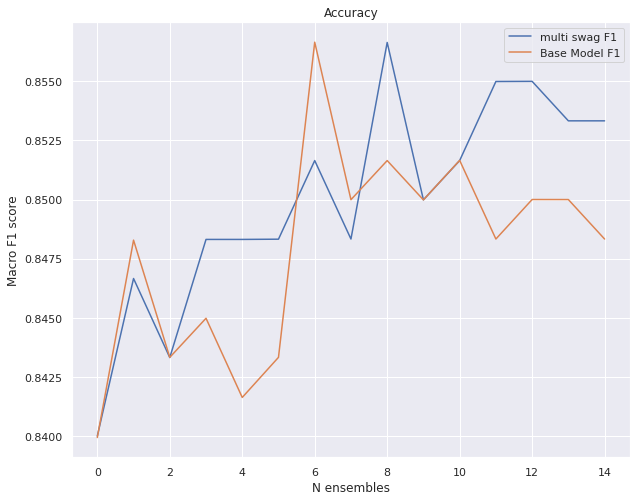

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(f1_ensembles, label='multi swag F1')
plt.plot(f1_base_ensembles, label='Base Model F1')
plt.title('Accuracy')
plt.ylabel('Macro F1 score')
plt.xlabel('N ensembles')
plt.legend()
plt.show()

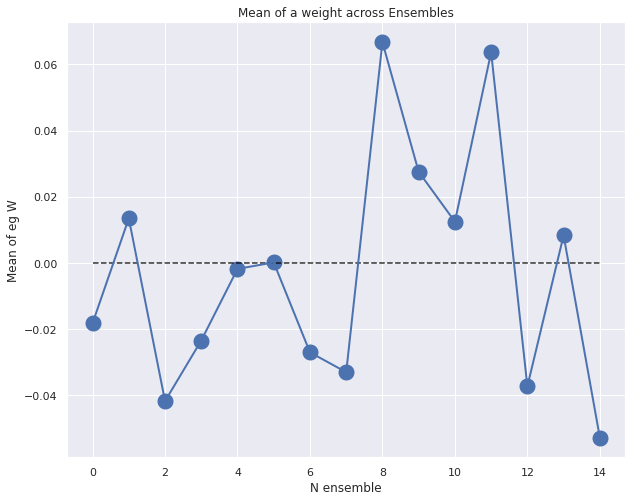

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.zeros(len(w_eg_mean)),color='black', alpha=0.8,linestyle='dashed')
plt.scatter(range(len(w_eg_mean)), w_eg_mean, marker='o',linewidths=10)
plt.plot(w_eg_mean, linewidth=2)
plt.title('Mean of a weight across Ensembles')
plt.ylabel('Mean of eg W')
plt.xlabel('N ensemble')
plt.show()

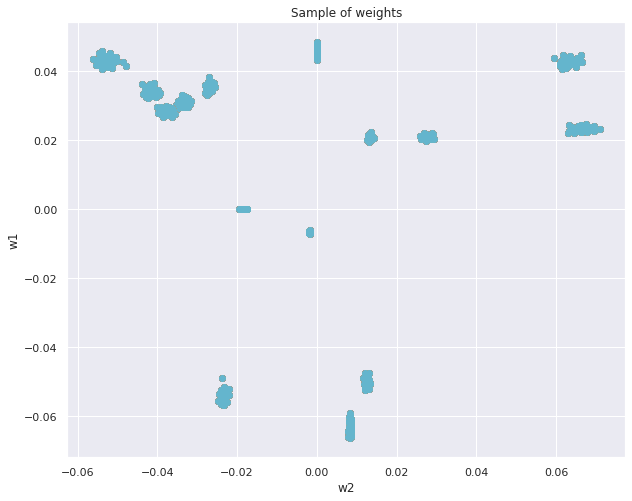

In [ ]:
plt.figure(figsize=(10,8))

for w1, w2 in zip(w_eg_true_all1, w_eg_true_all2):
  plt.scatter(w1,w2)

plt.title('Sample of weights')
plt.ylabel('w1')
plt.xlabel('w2')
plt.show()

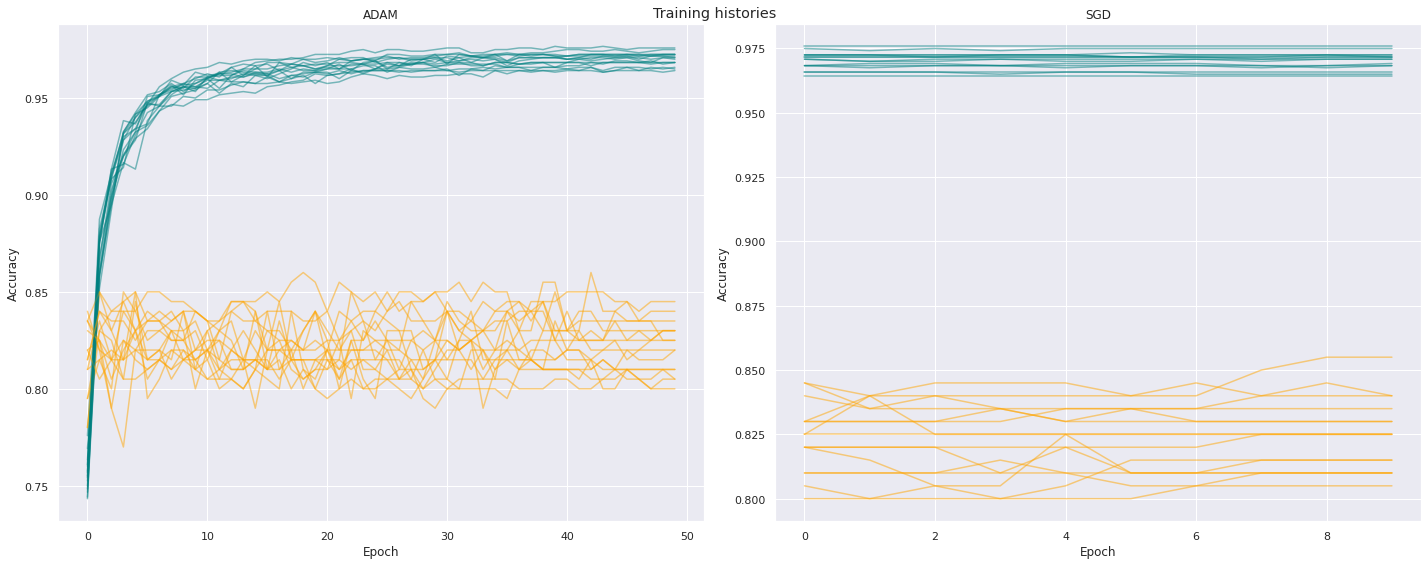

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(20,8))

#ADAM plot
for history in adam_train_history:
  train_acc = []
  for i in history['train_acc']:
    train_acc.append(i.cpu().detach().numpy())

  val_acc = []
  for i in history['val_acc']:
    val_acc.append(i.cpu().detach().numpy())
  
  ax1.plot(train_acc, label='train accuracy',color='teal',alpha=0.5)
  ax1.plot(val_acc, label='validation accuracy',color='orange',alpha=0.5)
  ax1.set_title('ADAM')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')

#SGD plot
for history in sgd_train_history:
  train_acc = []
  for i in history['train_acc']:
    train_acc.append(i.cpu().detach().numpy())

  val_acc = []
  for i in history['val_acc']:
    val_acc.append(i.cpu().detach().numpy())

  ax2.plot(train_acc, label='train accuracy',color='teal',alpha=0.5)
  ax2.plot(val_acc, label='validation accuracy',color='orange',alpha=0.5)
  ax2.set_title('SGD')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

plt.tight_layout()
fig.suptitle('Training histories')
plt.show()

# Model eval

In [ ]:
print((np.array(y_pred_probs_multi_swag).shape))
print((np.array(y_pred_probs_multi_swag).mean(axis=-3).shape))
print(np.argmax(np.array(y_pred_probs_multi_swag).mean(axis=-3),axis=1).shape)

(750, 600, 2)
(600, 2)
(600,)


In [ ]:
y_pred_swag_mean=np.argmax(np.array(y_pred_probs_multi_swag).mean(axis=-3),axis=1)
print(classification_report(y_test_multi_swag[0], y_pred_swag_mean,digits=4))

              precision    recall  f1-score   support

           0     0.8866    0.8243    0.8543       313
           1     0.8220    0.8850    0.8523       287

    accuracy                         0.8533       600
   macro avg     0.8543    0.8546    0.8533       600
weighted avg     0.8557    0.8533    0.8534       600



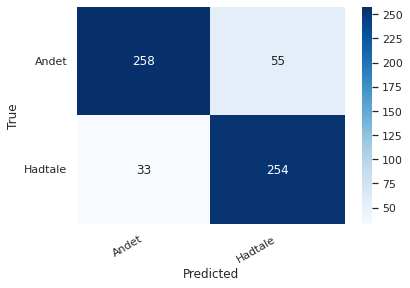

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

cm = confusion_matrix(y_test_multi_swag[0], np.argmax(np.array(y_pred_probs_multi_swag).mean(axis=-3),axis=1))
df_cm = pd.DataFrame(cm, index=['Andet','Hadtale'], columns=['Andet','Hadtale'])
show_confusion_matrix(df_cm)